In [7]:
#meta 5/3/2021 myClassify (multiclass) for WOS5736 - Train model with fast.ai
# task: classify text (multiclass) 
# input: ../input/mywos-train/WOS5736_df_tidy.pkl
#      WOS5736 ds with only 11 labels
#      Important reset index - fast.ai dataloaders don't like a gap in index
#      to avoid -> TypeError: 'float' object is not iterable

#task: Multi-class text classification - supervised
#based on helloML/myNLP_lshtc3/kaggle_1_classify.ipynb

#$config mystop


#history
#      5/3/2021 FAST.AI in Kaggle
#      Initial Accuracy (validation ds) ~77% 
#      Random train vs valid split

#      5/3/2021 FAST.AI in Kaggle, STRATIFIED SPLIT
#      Stratified train vs valid split
#      Accuracy (validation ds) improved to ~80 (79.77%)


In [8]:
%matplotlib inline
#import time as time #to track performance time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump


In [9]:
from fastai.text.all import *

In [10]:
#declare vars
SEED = 24

# LSHTC: Classify Text 
Train text classifier using Transfer Learning.  2 steps:  
1. fine-tune our language model pretrained on Wikipedia to the corpus of Expeditors survey  
2. use that model to train a classifier  



## 0. Load Data
input: a prepared pickle with pre-selected relevant fields.

In [11]:
df_tidy = load('../input/mywos-train/WOS5736_df_tidy.pkl') 
print(df_tidy.shape)
print(df_tidy.columns)
print(df_tidy.dtypes)
df_tidy.head()


(5736, 3)
Index(['text', 'label', 'is_valid'], dtype='object')
text          object
label       category
is_valid       int64
dtype: object


,text,label,is_valid
0,"Phytoplasmas are insect-vectored bacteria that cause disease in a wide range of plant species. The increasing availability of molecular DNA analyses, expertise and additional methods in recent years has led to a proliferation of discoveries of phytoplasma-plant host associations and in the numbers of taxonomic groupings for phytoplasmas. The widespread use of common names based on the diseases with which they are associated, as well as separate phenetic and taxonomic systems for classifying phytoplasmas based on variation at the 16S rRNA-encoding gene, complicates interpretation of the lit...",9,0
1,"Background: (-)-alpha-Bisabolol, also known as levomenol, is an unsaturated sesquiterpene alcohol that has mainly been used in pharmaceutical and cosmetic products due to its anti-inflammatory and skin-soothing properties. (-)-alpha-Bisabolol is currently manufactured mainly by steam-distillation of the essential oils extracted from the Brazilian candeia tree that is under threat because its natural habitat is constantly shrinking. Therefore, microbial production of (-)-alpha-bisabolol plays a key role in the development of its sustainable production from renewable feedstock. Results: Here...",7,0
2,"A universal feature of the replication of positive-strand RNA viruses is the association with intracellular membranes. Carnation Italian ringspot virus (CIRV) replication in plants occurs in vesicles derived from the mitochondrial outer membrane. The product encoded by CIRV ORF1, p36, is required for targeting the virus replication complex to the outer mitochondrial membrane both in plant and yeast cells. Here the yeast Saccharomyces cerevisiae was used as a model host to study the effect of CIRV p36 on cell survival and death. It was shown that p36 does not promote cell death, but decreas...",7,0
3,"1,2-Dichloropropane (1,2-DCP) and dichloromethane (DCM) are possible causative agents associated with the development of cholangiocarcinoma in employees working in printing plant in Osaka, Japan. However, few reports have demonstrated an association between these agents and cholangiocarcinoma in rodent carcinogenicity studies. Moreover, the combined effects of these compounds have not been fully elucidated. In the present study, we evaluated the in vivo mutagenicity of 1,2-DCP and DCM, alone or combined, in the livers of gpt delta rats. Six-week-old male F344 gpt delta rats were treated wi...",9,0
4,"This paper presents the simulation results of a linear, fully integrated, two-stage digitally programmable 130 nm CMOS power amplifier (PA) operating at 2.4 GHz. Its power stage is composed of a set of amplifying cells which can be enabled or disabled independently by a digital control circuit. All seven operational modes are univocal in terms of 1 dB output compression point (OCP1dB), saturated output power (P-SAT) and power gain at 2.4 GHz. The lowest power mode achieves an 8.1 dBm P-SAT, a 13.5 dB power gain and consumes 171 mW DC power (P-DC) at an OCP1dB of 6 dBm, whereas the highest ...",1,0


In [12]:
#clean df
df = df_tidy[['text', 'label', 'is_valid']].copy()
print(df['is_valid'].value_counts())

#reset index - dataloaders don't like a gap in index
#to fix error in next cell: TypeError: 'float' object is not iterable
#df.reset_index(drop=True, inplace=True)

df.head(2)

,text,label,is_valid
0,"Phytoplasmas are insect-vectored bacteria that cause disease in a wide range of plant species. The increasing availability of molecular DNA analyses, expertise and additional methods in recent years has led to a proliferation of discoveries of phytoplasma-plant host associations and in the numbers of taxonomic groupings for phytoplasmas. The widespread use of common names based on the diseases with which they are associated, as well as separate phenetic and taxonomic systems for classifying phytoplasmas based on variation at the 16S rRNA-encoding gene, complicates interpretation of the lit...",9,0
1,"Background: (-)-alpha-Bisabolol, also known as levomenol, is an unsaturated sesquiterpene alcohol that has mainly been used in pharmaceutical and cosmetic products due to its anti-inflammatory and skin-soothing properties. (-)-alpha-Bisabolol is currently manufactured mainly by steam-distillation of the essential oils extracted from the Brazilian candeia tree that is under threat because its natural habitat is constantly shrinking. Therefore, microbial production of (-)-alpha-bisabolol plays a key role in the development of its sustainable production from renewable feedstock. Results: Here...",7,0


0    4588
1    1148
Name: is_valid, dtype: int64

## 1. Data Prep for fast.ai
Prepare our data for the language model and for the classification model separately, using fast.ai library.

### 1.1 Data Prep for Language Model Using DataBlock
fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`. `DataBlock`'s handy `summary` method is useful for debugging data issues.


Putting Our Texts into Batches for a Language Model

In [15]:
#src https://docs.fast.ai/text.data.html#TextDataLoaders.from_df
#dls_lm = TextDataLoaders.from_df(df, path=path, text_col='text', is_lm=True, valid_col='is_valid')
dls_lm = TextDataLoaders.from_df(df, text_col='text', is_lm=True, splitter=ColSplitter()) 
dls_lm.show_batch(max_n=3)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj the present review examines how macromolecular structure and functional groups of pectin affect its functionality with particular focus on its interfacial activity . xxmaj we venture into a description of the particularly complex pectin structure and describe the major building blocks and their properties . xxmaj in the following section , the role of each structural parameter is discussed with particular attention to protein , degree of acetylation and methylation","xxmaj the present review examines how macromolecular structure and functional groups of pectin affect its functionality with particular focus on its interfacial activity . xxmaj we venture into a description of the particularly complex pectin structure and describe the major building blocks and their properties . xxmaj in the following section , the role of each structural parameter is discussed with particular attention to protein , degree of acetylation and methylation ,"
1,"conjugated xxup np was observed , which was accompanied by the pronounced up - regulation of co - stimulatory molecule and cytokine production . ( c ) 2016 xxmaj elsevier xxmaj ltd . xxmaj all rights reserved . xxbos xxmaj aberrant expression of micrornas ( mirnas ) and processing defects in their biogenesis pathway are a widespread phenomenon in tumors , conveying great importance to the analysis of mirna expression , regulation","xxup np was observed , which was accompanied by the pronounced up - regulation of co - stimulatory molecule and cytokine production . ( c ) 2016 xxmaj elsevier xxmaj ltd . xxmaj all rights reserved . xxbos xxmaj aberrant expression of micrornas ( mirnas ) and processing defects in their biogenesis pathway are a widespread phenomenon in tumors , conveying great importance to the analysis of mirna expression , regulation ,"
2,"pcr and xxmaj northern blotting were used to determine the tissue distribution of xxmaj gpr128 mrna . xxmaj beginning at the age of 4 wk , body weights were recorded every 4 wk . xxmaj food , feces , blood and organ samples were collected to analyze food consumption , fecal quantity , organ weight and constituents of the blood and plasma . a xxmaj xxunk preparation was utilized to examine intestinal","and xxmaj northern blotting were used to determine the tissue distribution of xxmaj gpr128 mrna . xxmaj beginning at the age of 4 wk , body weights were recorded every 4 wk . xxmaj food , feces , blood and organ samples were collected to analyze food consumption , fecal quantity , organ weight and constituents of the blood and plasma . a xxmaj xxunk preparation was utilized to examine intestinal motility"


In [16]:
#dataset dims
len(dls_lm.train_ds), len(dls_lm.valid_ds)

(4589, 1147)

In [18]:
#view vocab, class list
print("LM vocab size: ", len(dls_lm.vocab))
dls_lm.vocab[5:100]

LM vocab size:  21408


[',',
 '.',
 'of',
 'and',
 'in',
 '-',
 'to',
 ')',
 '(',
 'a',
 'with',
 'for',
 'is',
 'that',
 'was',
 'by',
 'were',
 'this',
 'as',
 'on',
 'are',
 'from',
 'we',
 'an',
 ':',
 '/',
 'be',
 '%',
 'or',
 'expression',
 'results',
 'study',
 'at',
 'these',
 'which',
 'cells',
 'have',
 'using',
 'patients',
 'has',
 'cell',
 'all',
 'can',
 'between',
 'c',
 'not',
 'control',
 'analysis',
 'it',
 'been',
 'their',
 'also',
 'used',
 'based',
 'high',
 'system',
 'gene',
 'time',
 ';',
 'protein',
 'may',
 'more',
 'two',
 'associated',
 'both',
 'than',
 'but',
 'levels',
 'power',
 'different',
 'treatment',
 '=',
 'its',
 '3',
 'molecular',
 'current',
 'however',
 'cancer',
 '1',
 'methods',
 'data',
 'model',
 'social',
 'compared',
 'showed',
 'after',
 'such',
 'elsevier',
 'our',
 'genes']

Data is ready, we can fine-tune the pretrained language model.

## 2. Model
The LM was pretrained on Wikipedia.  Fine-tune this LM to Expeditors survey corpus, and then use that as the base for our classifier.  
![ULMFiT Process](my-images/ch10_ULMFIT_process.png)
### 2.1 Fine-Tuning the Language Model


In [19]:
#class fastai.text.learner.LMLearner
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

0.014454 1e-06


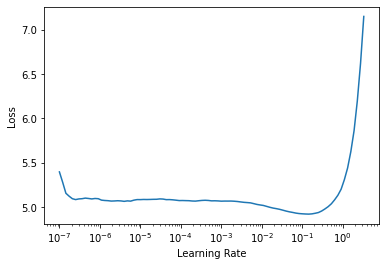

In [20]:
#select the appropriate lr
#learn.lr_find()
lr1, lr2 = learn.lr_find()
print(round(lr1, 6), round(lr2, 6))

In [22]:
#mystop

In [23]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.217974,4.101266,0.323998,60.416752,01:08


In [24]:
#save and load models
learn.save('1epoch')
#learn = learn.load('1epoch')

Path('models/1epoch.pth')

In [25]:
learn = learn.load('1epoch')

Once the initial training has completed, continue fine-tuning the model after unfreezing

In [26]:
learn.unfreeze()
learn.fit_one_cycle(5, 4e-3) 

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.815489,4.080278,0.324417,59.161911,01:15
1,3.627152,3.983913,0.334460,53.726852,01:16
2,3.176207,3.981167,0.338302,53.579540,01:16
3,2.640876,4.068605,0.336953,58.475357,01:15
4,2.228607,4.182691,0.332498,65.541962,01:15


In [27]:
#save model encoder
learn.save_encoder('finetuned')

In [28]:
#class fastai.text.learner.LMLearner
#learn.summary()

##### Text generation

In [29]:
TEXT = "The aim of this study was"
N_WORDS = 40
N_SENTENCES = 2
#to predict, must be of class fastai.text.learner.LMLearner
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n".join(preds))

The aim of this study was to investigate the effect of high - intensity epileptiform activity on self - reported neural activity in the brain formed by the UNITARY network . The activity of theta was measured using a cell - specific X
The aim of this study was to examine the association between two life events ( physical and emotional abuse and neglect ) and to explore different types of causal links between alcohol and alcohol use . This study was conducted in a large sample of


In [30]:
TEXT = "This paper presents"
N_WORDS = 40
N_SENTENCES = 2
#to predict, must be of class fastai.text.learner.LMLearner
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n".join(preds))

This paper presents an analysis of the power dissipation of a compact circuits with the use of the theory of mind - tom theory . The test is based on a methodology to study the performance of the theory of mind .
This paper presents a three - dimensional ( 3d ) printing framework for integrated hybrid printing combined with printed / non - polishing printing for various manufacturing processes . The measurement of the printed parts on optical electrodes is an ongoing process


In [32]:
#mystop

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### 1.2 Data Prep for Classifier Model Using DataBlock
Creating the Classifier DataLoaders

In [33]:
dls_clf = TextDataLoaders.from_df(df, text_col='text', label_col='label', vocab=dls_lm.vocab, splitter=ColSplitter())
dls_clf.show_batch(max_n=3)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj fresh ( frozen / thawed ) muscle samples from four 2 - xxunk - old roe deer ( xxunk xxunk ) from the xxmaj xxunk province in north - eastern xxmaj italy were examined under a dissecting microscope , and about 180 sarcocysts were isolated and identified to morphological type in wet xxunk by light microscopy ( lm ) . xxmaj seventy - seven of these sarcocysts were subsequently examined by molecular methods , comprising polymerase chain reaction ( pcr ) amplification and sequencing of the partial cytochrome c oxidase subunit i gene ( cox1 ) of all isolates , as well as xxup pcr amplification , cloning and sequencing of the xxunk ribosomal xxup rna ( rrna ) gene of two isolates of each species found . xxmaj by xxup lm , three major xxunk types were recognised : spindle - shaped sarcocysts , 0.5 - 3",9
1,"xxbos xxmaj background : xxmaj in many parts of the xxmaj old xxmaj world , domesticated camels ( genus - xxmaj camelus ) are an essential resource , providing food , labor , commodities , and sport to millions of people xxmaj of the three extent species , two have been domesticated ( single - humped xxunk , xxmaj camelus xxunk , and two humped xxmaj bactrian camels xxmaj camelus xxunk ) and one remains wild ( two - humped wild xxmaj bactrian camels xxmaj camelus xxunk ) . xxmaj all three species possess a variety adaptations to harsh desert conditions , including mechanisms to tolerate of extreme temperatures , dehydration , and sandy terrain . xxmaj people residing in harsh climate zones of the world are being xxunk by raising camels in terms of draft , milk , meat , xxunk and xxunk from centuries . xxmaj there are",7
2,"xxbos xxmaj background : xxmaj variable ventilation has been shown to improve pulmonary function and reduce lung damage in different models of acute respiratory distress syndrome . xxmaj nevertheless , variable ventilation has not been tested during pneumonia . xxmaj theoretically , periodic increases in tidal volume ( xxunk ) and airway pressures might worsen the impairment of alveolar barrier function usually seen in pneumonia and could increase bacterial translocation into the bloodstream . xxmaj we investigated the impact of variable ventilation on lung function and histologic damage , as well as markers of lung inflammation , epithelial and endothelial cell damage , and alveolar stress , and bacterial translocation in experimental pneumonia . xxmaj methods : xxmaj thirty - two xxmaj wistar rats were randomly assigned to receive xxunk of xxmaj pseudomonas aeruginosa ( pa ) or saline ( sal ) ( n = 16 / group ) .",7


In [34]:
len(dls_clf.train_ds), len(dls_clf.valid_ds)

(4589, 1147)

### 2.2 Model Classifier

In [35]:
#class fastai.text.learner.TextLearner
learn = text_classifier_learner(dls_clf, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

Prior to training the classifier, load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded

In [36]:
learn = learn.load_encoder('finetuned')

##### Fine-tune classifier
The last step is to train with discriminative learning rates and *gradual unfreezing*. In computer vision we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference

0.036308 0.022909


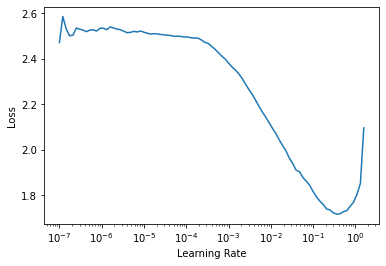

In [37]:
#select the appropriate lr
#learn.lr_find()
lr1, lr2 = learn.lr_find()
print(round(lr1, 6), round(lr2, 6))

In [38]:
#mystop

In [39]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.015144,0.671576,0.761116,00:14


In just one epoch we get the same result as our training in <<chapter_intro>>: not too bad! We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [40]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(4e-3/(2.6**4),4e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.759187,0.596185,0.784656,00:17


Unfreeze more and train

In [41]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.647324,0.576072,0.791630,00:25


Finally, the whole model

In [42]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.629981,0.574778,0.799477,00:31
1,0.622097,0.564398,0.797733,00:31


We reached 79+% accuracy (almost 80%) 

Using a pretrained model let us build a fine-tuned language model that was pretty powerful, to either generate fake reviews or help classify them. This is exciting stuff!

In [43]:
#learn.summary()
learn.show_results()

,text,category,category_
0,"xxbos xxup background & xxup aims : xxmaj infections are common in patients with severe alcoholic hepatitis ( sah ) , but little information is available on how to predict their development or their effects on patients . xxmaj prednisolone is advocated for treatment of xxup sah , but can increase susceptibility to infection . xxmaj we compared the effects of infection on clinical outcomes of patients treated with and without prednisolone , and identified risk factors for development of infection in xxup sah . xxup methods : xxmaj we analyzed data from xxunk patients enrolled in a double - blind xxunk trial to evaluate the efficacy of treatment with prednisolone ( 40 mg daily ) or pentoxifylline ( 400 mg 3 times each day ) in patients with xxup sah . xxmaj the 2 x 2 factorial design led to xxunk patients receiving prednisolone ; 546 were treated with",9,9
1,"xxbos xxmaj we investigated the effects of embryonic temperature ( et ) treatments ( 22 , 26 and 31 degrees xxup c ) on the life - time recruitment of fast xxunk muscle fibres in zebrafish xxmaj danio rerio xxup l. reared at 26 / 27 degrees c from xxunk . xxmaj fast muscle fibres were produced until 25 mm total length ( tl ) at 22 degrees c xxup et , 28 mm xxup tl at 26 degrees c xxup et and 23 mm xxup tl at 31 degrees c xxup et . xxmaj the final fibre number ( xxunk ) showed an optimum at 26 degrees c xxup et ( xxunk ) and was 19 % and 14 % higher than for the 22 degrees c xxup et ( 3 xxrep 3 0 ) and 31 c xxup et ( xxunk ) treatments , respectively . xxmaj further",10,10
2,"xxbos a novel , optimized numerical method of modeling of an exciton polariton xxunk in a semiconductor xxunk was proposed . xxmaj exciton polaritons are spin - carrying xxunk formed from photons strongly coupled to xxunk . xxmaj they possess unique properties , interesting from the point of view of fundamental research as well as numerous potential applications . xxmaj however , their numerical modeling is challenging due to the structure of nonlinear differential equations describing their evolution . xxmaj in this paper , we propose to solve the equations with a modified xxmaj runge xxmaj kutta method of 4th order , further optimized for efficient computations . xxmaj the algorithms were implemented in form of xxup c++ programs fitted for parallel environments and utilizing vector instructions . xxmaj the programs form the xxup xxunk suite which has been used for theoretical investigation of exciton polaritons . xxmaj program summary",6,7
3,"xxbos xxmaj background : xxmaj novel therapies for men with castration - resistant prostate cancer ( crpc ) are needed , particularly for cancers not driven by androgen receptor ( ar ) activation . xxmaj objectives : xxmaj to identify molecular subgroups of xxup pc bone metastases of relevance for therapy . xxmaj design , setting , and participants : xxmaj fresh - frozen bone metastasis samples from men with xxup crpc ( n = 40 ) , treatment - nai "" ve xxup pc ( n = 8) , or other malignancies ( n = 12 ) were characterized using whole - genome expression profiling , multivariate principal component analysis ( pca ) , and functional enrichment analysis . xxmaj expression profiles were verified by reverse transcription - polymerase chain reaction ( rt - pcr ) in an extended set of bone metastases ( n = 77 ) and",9,9
4,"xxbos xxmaj aim of study - to estimate leptin gene ( arg223gln ) genotypes polymorphism in patients with coronary heart disease and obesity . xxmaj materials and xxmaj methods . xxrep 3 2 patients with the coronary heart disease ( chd ) and obesity have been comprehensively examined . xxmaj all patients were on treatment in xxunk unit of xxup xxunk of the xxmaj xxunk city hospital . 27 , which is the basic clinic of xxmaj department of xxmaj internal xxmaj medicine . 2 and xxmaj clinical xxmaj immunology and xxmaj xxunk of the xxmaj xxunk xxmaj national xxmaj medical xxmaj university of xxup mh of xxmaj ukraine . xxmaj the 

In [44]:
#save final model
learn.save('clf_final')
#export model as pkl
learn.export()

In [45]:
#mystop

## 3. Model Evaluation
src https://docs.fast.ai/interpret.html#ClassificationInterpretation  
src code https://github.com/fastai/fastai/blob/master/fastai/interpret.py#L51
### 3.1 Report and Confusion Matrix

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.86      0.96      0.90        94
           1       0.85      0.94      0.89        71
           2       0.98      0.86      0.91        97
           3       0.75      0.89      0.81        74
           4       0.88      0.88      0.88        85
           5       0.74      0.70      0.72        73
           6       0.68      0.54      0.60        81
           7       0.77      0.62      0.69       154
           8       0.78      0.76      0.77       123
           9       0.70      0.78      0.74       140
          10       0.82      0.91      0.86       155

    accuracy                           0.80      1147
   macro avg       0.80      0.80      0.80      1147
weighted avg       0.80      0.80      0.79      1147



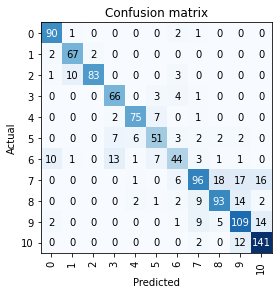

In [47]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [48]:
interp.most_confused(min_val = 10)

[(7, 8, 18),
 (7, 9, 17),
 (7, 10, 16),
 (8, 9, 14),
 (9, 10, 14),
 (6, 3, 13),
 (10, 9, 12),
 (2, 1, 10),
 (6, 0, 10)]

In [49]:
interp.plot_top_losses(10)

,input,target,predicted,probability,loss
0,"xxbos xxmaj the traditional critical conduction mode ( crm ) flyback xxup pfc converter with constant on - time control strategy usually suffers low power factor ( pf ) and high total harmonic distortion ( thd ) due to the xxunk input current waveform . xxmaj in order to solve this problem , an improved variable on - time control strategy for the xxup crm flyback xxup pfc converter is proposed in this letter . a simple analog divider circuit consisting of an operational amplifier , two signal switches , and an xxup rc filter is proposed to modulate the turn - on time of the primary switch , and the xxup pf and xxup thd of the xxup crm flyback xxup pfc converter can be evidently improved . xxmaj the theoretical analysis is presented and the experiment results verify the advantages of the proposed control scheme .",2,1,0.9988142251968384,7.059780597686768
1,"xxbos xxmaj context : xxmaj amitriptyline , a xxunk antidepressant is used for the management of psychological disorders and various types of pain . xxmaj in the previous work , it is founded that amitriptyline inhibited the migration of polymorphonuclear ( xxunk ) into the site of inflammation . xxmaj aims : xxmaj to evaluate the effect of amitriptyline on the expression of some inflammatory mediators such as intercellular adhesion molecule ( icam-1 ) , vascular cell adhesion molecule ( vcam-1 ) , cyclooxygenase 2 ( cox2 ) and inducible nitric oxide synthase ( inos ) . xxmaj methods : xxmaj an in vitro model system of lps - stimulated human endothelial cells and xxup u-937 macrophages and also in vivo model of carrageenan - induced paw edema in rat were used . xxmaj the expression of inflammatory mediator genes was determined by qrt - real - time xxup pcr",5,9,0.4926927387714386,6.697127342224121
2,"xxbos xxmaj combat - related posttraumatic stress disorder ( ptsd ) is common among returning veterans , and is a serious and debilitating disorder . xxmaj while highly effective treatments involving trauma exposure exist , difficulties with engagement and early drop may lead to sub - optimal outcomes . xxmaj mindfulness training may provide a method for increasing emotional regulation skills that may improve engagement in trauma - focused therapy . xxmaj here , we examine potential neural correlates of mindfulness training and in vivo exposure ( non - trauma focused ) using a novel group therapy [ mindfulness - based exposure therapy ( mbet ) ] in xxmaj afghanistan ( off ) or xxmaj iraq ( oif ) combat veterans with xxup ptsd . xxup off / xxup oif combat veterans with xxup ptsd ( n = 23 ) were treated with xxup mbet ( n = 14 )",4,5,0.5918794274330139,5.546913146972656
3,xxbos xxmaj output voltage and an inverting input voltage of inverting amplifier circuit are measured when conducted disturbance is injected to power supply pin by xxup dpi measurement . xxmaj correlation between output voltage and inverting input voltage is shown .,2,6,0.2546985447406769,5.127928733825684
4,xxbos xxmaj three methods of operational amplifier ( op amp ) slew rate verification are considered . xxmaj these methods are illustrated through the example of xxup spice macro models of xxmaj op amp xxup xxunk by xxmaj texas xxmaj instruments and xxup xxunk by xxmaj analog xxmaj devices .,2,6,0.2546985447406769,5.127928733825684
5,xxbos xxmaj peripartum cardiomyopathy is a heart failure syndrome occurring late in pregnancy or during the early post - natal period . xxmaj the pathophysiology of peripartum cardiomyopathy is not fully understood and various mechanisms have been postulated including an underlying inflammatory process . xxmaj we here report four cases presenting with acute left ventricular systolic dysfunction . xxmaj three out of four of the patients presented with a left ventricular ejection fraction < 30 % and one with a left ventricular ejection fraction of 35 % . xxmaj all made a full clinical recovery following treatment with high - dose intraveno

#### 4. Predict

In [50]:
learn_inf = load_learner('/kaggle/working/export.pkl')
learn_inf.predict("the simulation results of a linear, fully integrated, two-stage digitally programmable 130 nm CMOS power amplifier (PA) operating at 2.4 GHz. Its power stage is composed of a set of amplifying cells which can be enabled or disabled independently by a digital control circuit. All seven operational modes are univocal in terms of 1")

('1',
 tensor(1),
 tensor([1.3767e-04, 8.2131e-01, 1.7818e-01, 4.7224e-05, 3.3206e-05, 2.9331e-06,
         1.0940e-06, 8.6787e-06, 6.5005e-05, 2.6391e-05, 1.8831e-04]))

In [51]:
mystop

NameError: name 'mystop' is not defined

## Xtra. Data Prep for ML


In [ ]:
#interested in words in all rows, column 0
#this text_train
X = df['FINAL_COMMENT'].copy()
X.shape


In [ ]:
#for supervised learning
y = df['Q_NPS_CAT'].copy()
print(y.shape)
y.head()


In [ ]:
print(y.value_counts().sort_index())
y.value_counts().sort_index().plot(kind="bar")

In [ ]:
import fastai
from fastai import *
from fastai.text import *

#from IPython.display import display,HTML 

In [ ]:
#$was
# use TextBlock to create a language model, pass TextBlock to DataBlock
#es_lm = DataBlock(
#    blocks=TextBlock.from_df('text', seq_len=72, is_lm=True),
##    #get_x=ColReader('text'), 
#    splitter=RandomSplitter(0.2, seed = SEED)) 

#dataloaders
#dls_lm = es_lm.dataloaders(df['text'], bs=64)
#dls_lm.show_batch(max_n=2)

In [ ]:
#src https://forums.fast.ai/t/the-interpretation-of-text-classification-throws-an-error-when-used-on-a-pretrained-network/39471
def show_piece_attn(*args, **kwargs):
    from IPython.display import display, HTML
    display(HTML(piece_attn_html(*args, **kwargs)))

def _eval_dropouts(mod):
        module_name =  mod.__class__.__name__
        if 'Dropout' in module_name or 'BatchNorm' in module_name: mod.training = False
        for module in mod.children(): _eval_dropouts(module)
            
class TextClassificationInterpretation(ClassificationInterpretation):
    """Provides an interpretation of classification based on input sensitivity.
    This was designed for AWD-LSTM only for the moment, because Transformer already has its own attentional model.
    """

    def __init__(self, learn: Learner, preds: Tensor, y_true: Tensor, losses: Tensor, ds_type: DatasetType = DatasetType.Valid):
        super(TextClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.model = learn.model

    def intrinsic_attention(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`. """

In [ ]:
#https://github.com/fastai/fastai/pull/2115/files
#from fastai.train import ClassificationInterpretation

#from fastai.data.all import *
from fastai.basic_train import Learner #fastai v1 is not compatible vith v2
from fastai.vision import DatasetType


__all__ = ['TextClassificationInterpretation']

print(fastai.DatasetType.valid)

class TextClassificationInterpretation(ClassificationInterpretation):
    """Provides an interpretation of classification based on input sensitivity.
    This was designed for AWD-LSTM only for the moment, because Transformer already has its own attentional model.
    """

    def __init__(self, learn: Learner, preds: Tensor, y_true: Tensor, losses: Tensor, ds_type: DatasetType = DatasetType.Valid):
        super(TextClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.model = learn.model

    def intrinsic_attention(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`.
        For reference, see the Sequential Jacobian session at https://www.cs.toronto.edu/~graves/preprint.pdf
        """
        self.model.train()
        _eval_dropouts(self.model)
        self.model.zero_grad()
        self.model.reset()
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        cl = self.model[1](lstm_output + (torch.zeros_like(ids).byte(),))[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max()
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn

    def html_intrinsic_attention(self, text:str, class_id:int=None, **kwargs)->str:
        text, attn = self.intrinsic_attention(text, class_id)
        return piece_attn_html(text.text.split(), to_np(attn), **kwargs)

    def show_intrinsic_attention(self, text:str, class_id:int=None, **kwargs)->None:
        text, attn = self.intrinsic_attention(text, class_id)
        show_piece_attn(text.text.split(), to_np(attn), **kwargs)

    def show_top_losses(self, k:int, max_len:int=70)->None:
        """
        Create a tabulation showing the first `k` texts in top_losses along with their prediction, actual,loss, and probability of
        actual class. `max_len` is the maximum number of tokens displayed.
        """
        from IPython.display import display, HTML
        items = []
        tl_val,tl_idx = self.top_losses()
        for i,idx in enumerate(tl_idx):
            if k <= 0: break
            k -= 1
            tx,cl = self.data.dl(self.ds_type).dataset[idx]
            cl = cl.data
            classes = self.data.classes
            txt = ' '.join(tx.text.split(' ')[:max_len]) if max_len is not None else tx.text
            tmp = [txt, f'{classes[self.pred_class[idx]]}', f'{classes[cl]}', f'{self.losses[idx]:.2f}',
                   f'{self.preds[idx][cl]:.2f}']
            items.append(tmp)
        items = np.array(items)
        names = ['Text', 'Prediction', 'Actual', 'Loss', 'Probability']
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False))) 

In [ ]:
learn.model

In [ ]:
for m in learn.model.modules():
    print('--')
    print(m)